In [1]:
# Переходим к работе с данными. Импортируем модули, которые нам понадобятся:

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

In [10]:
# Прочитаем данные о собранных образцах воды и выведем первые пять строк таблицы:

water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64

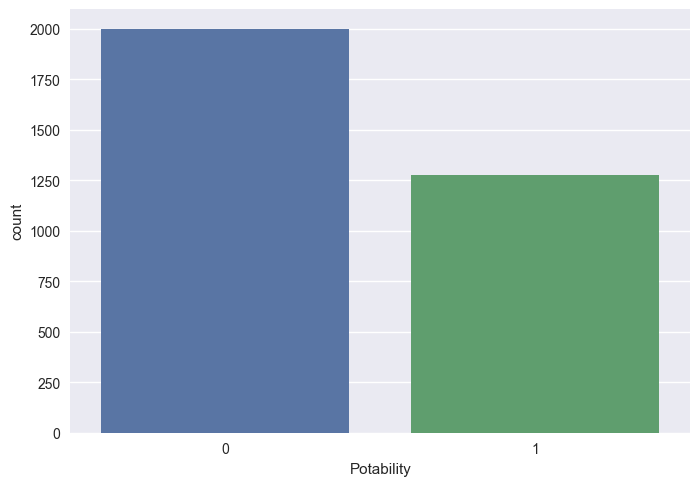

In [3]:
#Рассмотрим влияние дисбаланса на примере датасета о качестве воды. Посмотрим на соотношения классов внутри датасета:

display(water_data['Potability'].value_counts(normalize=True))
sns.countplot(data=water_data, x='Potability');

In [3]:
# СТРАТИФИЦИРОВАННОЕ РАЗБИЕНИЕ (stratified)

# Давайте на примере рассмотрим, как производить стратифицированное разбиение. Начнём с простого разделения 
# hold-out, которое мы проводим с помощью функции train_test_split(). Для начала проведём обычное случайное 
# разбиение на тренировочную и валидационную выборку (в соотношении 80/20) без стратификации:

X, y = water_data.drop('Potability', axis=1), water_data['Potability']
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.620229
1    0.379771
Name: proportion, dtype: float64
Valid:
Potability
0    0.568598
1    0.431402
Name: proportion, dtype: float64


In [4]:
# Для стратифицированного разбиения достаточно в функции train_test_split() задать параметр stratify, в который 
# нужно передать столбец с метками классов, на основе которого будет производиться балансировка. Это будет столбец 
# с правильными ответами y.

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
print('Train:\n', y_train.value_counts(normalize=True), sep='')
print('Valid:\n', y_valid.value_counts(normalize=True), sep='')

Train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64
Valid:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


In [5]:
# А что насчёт кросс-валидации? Как организовать разбиение по методу k-fold и получить одинаковые соотношения классов?
# Для этого вместо KFold используется кросс-валидатор StratifiedKFold. Принцип работы с ним аналогичен, только, 
# в отличие от KFold, StratifiedKFold будет разбивать выборку на части таким образом, чтобы в тренировочных и 
# валидационных фолдах соотношения классов были приблизительно одинаковыми.

skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, valid_index in skf.split(X, y): 
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    print('Train:\n', y_train.value_counts(normalize=True), sep='')
    print('Valid:\n', y_valid.value_counts(normalize=True), sep='')
    print('-'*40)

Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------
Train:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
Valid:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
----------------------------------------


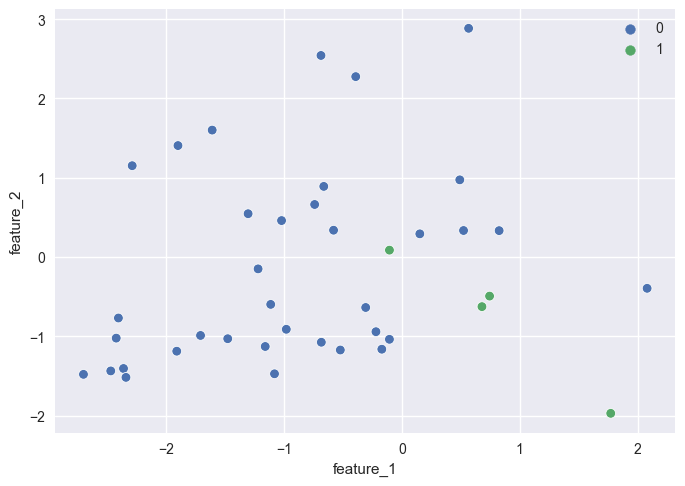

In [13]:
from sklearn import datasets
X, y = datasets.make_classification(
    n_samples=200, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    weights=[1, 0.2], #пропорции классов
    random_state=40 #генератор случайных чисел
)
X = pd.DataFrame(X, columns=['feature_1', 'feature_2'])
y = pd.Series(y)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);

In [11]:
# ВЫБОР МЕТРИК В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ

# Разобьём выборку на тренировочную и валидационную в соотношении 80/20, используя стратифицированное разбиение, 
# затем обучим модель дерева решений, сделаем предсказание для каждой из выборок и сформируем отчёт о метриках на 
# валидационной выборке с помощью функции classification_report().

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



In [21]:
# Сделайте предсказание для валидационной выборки и рассчитайте метрики классификации. Ответ округлите до двух знаков после точки-разделителя.

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);
log_reg_2d = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X_train, y_train)
y_train_pred = log_reg_2d.predict(X_train)
y_valid_pred = log_reg_2d.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90        36
           1       0.33      0.75      0.46         4

    accuracy                           0.82        40
   macro avg       0.65      0.79      0.68        40
weighted avg       0.90      0.82      0.85        40



In [15]:
#Функция для визуализации модели
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Glucose изменяется от x1_min = 44 до x2_max = 199, 
    #BMI — от x2_min = 18.2 до x2_max = 67.1
    #Результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказывает вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линия, где вероятность равна 0.5.
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


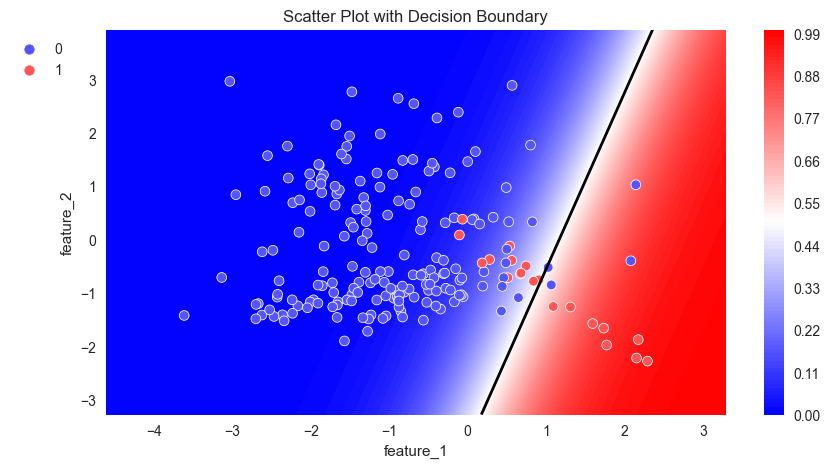

In [19]:
# Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того, 
# чтобы построить разделяющую поверхность логистической регрессии.

plot_probabilities_2d(X, y, log_reg_2d)

c:\Users\spbda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


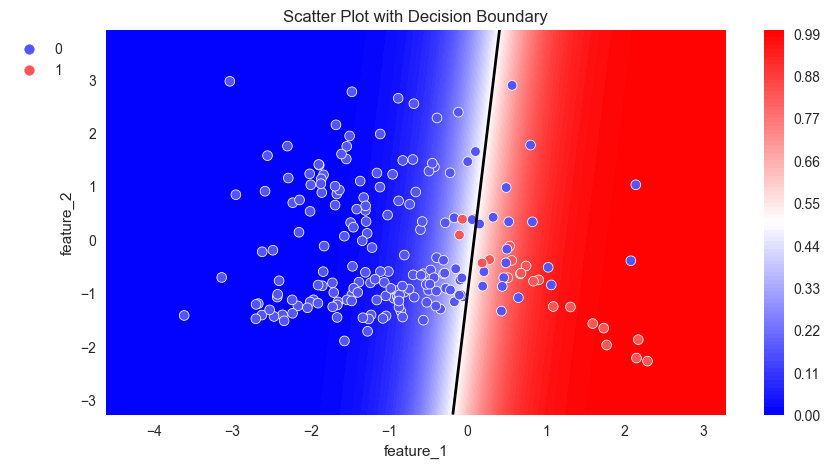

In [22]:
# Воспользуйтесь функцией plot_probabilities_2d(), которую мы написали в модуле по классификации, для того, чтобы 
# построить разделяющую поверхность логистической регрессии со сбалансированными весами классов.
plot_probabilities_2d(X, y, log_reg_2d)

In [20]:
# ПОСТРОЕНИЕ МОДЕЛИ В УСЛОВИЯХ ДИСБАЛАНСА КЛАССОВ
# ВЗВЕШИВАНИЕ ОБЪЕКТОВ

# Для того чтобы задать веса классам по приведённым выше формулам, достаточно в инициализаторе модели выставить 
# параметр class_weight='balanced'.

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



In [24]:
# ВЫБОР ПОРОГА ВЕРОЯТНОСТИ. PR-КРИВАЯ

# Для предсказания вероятностей используем функцию cross_val_predict(). Данная функция выполняет кросс-валидацию и 
# возвращает предсказания для валидационных фолдов. Если ей передать параметр method='predict_proba', она вернёт 
# предсказанные вероятности для каждого из классов на всех фолдах. Остальные параметры аналогичны параметрам функции 
# cross_validate().

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел 
)
#Обучаем модель
model.fit(X_train, y_train)
#Создаём кросс-валидатор k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.44444444, 0.55555556],
       [0.44444444, 0.55555556],
       [0.44444444, 0.55555556],
       [0.44444444, 0.55555556],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

In [25]:
# Нас интересует класс 1 (пригодная для питья вода). Это второй столбец в матрице вероятностей (индекс 1). Выделим 
# этот столбец из матрицы с вероятностями:

#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [26]:
# Теперь мы можем построить PR-кривую. Для этого воспользуемся функций precision_recall_curve() из модуля metrics 
# библиотеки sklearn. В данную функцию нужно передать истинные метки классов и предсказанные вероятности. Взамен 
# она вернёт три массива: значения метрик precision и recall, вычисленных на различных порогах вероятности, и сами 
# пороги вероятности:

#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.         0.16666667 0.25       0.28571429 0.5       ]
Precision scores: [0.1        0.48275862 0.5        0.59090909 0.61904762]
Recall scores: [1.     0.875  0.875  0.8125 0.8125]


Best threshold = 0.56, F1-Score = 0.74


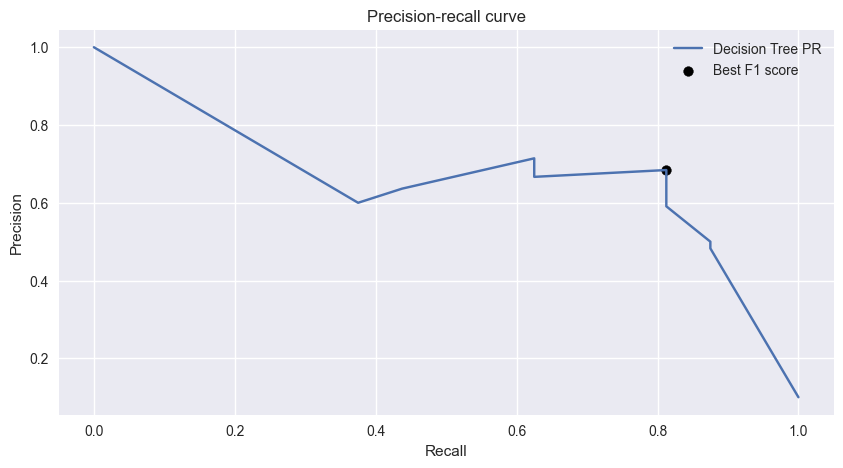

In [27]:
# Осталось дело за малым. Вычислим значение -score при различных порогах вероятности и найдём такой порог 
# вероятности, при котором она максимальна. Сделать это можно с помощью функции argmax() из модуля numpy — она 
# возвращает индекс максимального элемента массива.

# Далее построим PR-кривую и отметим на ней точку максимума -score.

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [28]:
# Сделаем предсказание классов с таким порогом для всех объектов из отложенной валидационной выборки и выведем отчёт 
# о метриках:

#Задаём оптимальный порог вероятностей
threshold_opt = 0.56
#Образцы воды, для которых вероятность быть пригодными для питья > threshold_opt, относим к классу 1
#В противном случае — к классу 0
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        36
           1       0.50      0.50      0.50         4

    accuracy                           0.90        40
   macro avg       0.72      0.72      0.72        40
weighted avg       0.90      0.90      0.90        40



In [29]:
# Примечание. Чтобы вычислить площадь под PR-кривой, используется функция auc() из модуля metrics библиотеки sklearn. 
# В данную функцию нужно передать значения метрик recall и precision при различных порогах вероятности:

print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))
# PR AUC: 0.79

PR AUC: 0.66


In [30]:
# СЭМПЛИРОВАНИЕ — пересэмплирование (oversampling)

# Алгоритмов сэмплирования, в том числе SMOTE, нет в стандартном пакете sklearn — они содержатся в библиотеке 
# imblearn (imbalanced-learn). Команды для установки приведены далее.

# Для пользователей pip:

!pip install imbalanced-learn

# Все алгоритмы пересэмплирования находятся в модуле over_sampling библиотеки imblearn. Импортируем оттуда алгоритм SMOTE:

from imblearn.over_sampling import SMOTE


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



                                              0.0/258.3 kB ? eta -:--:--
     ---------                               61.4/258.3 kB 1.1 MB/s eta 0:00:01
     ----------------------                 153.6/258.3 kB 1.5 MB/s eta 0:00:01
     -------------------------------        215.0/258.3 kB 1.9 MB/s eta 0:00:01
     -------------------------------        215.0/258.3 kB 1.9 MB/s eta 0:00:01
     -------------------------------        215.0/258.3 kB 1.9 MB/s eta 0:00:01
     --------------------------------     235.5/258.3 kB 801.7 kB/s eta 0:00:01
     ------------------------------------ 258.3/258.3 kB 835.3 kB/s eta 0:00:00


"conda" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [31]:
# Создадим объект класса SMOTE и вызовем у него метод fit_resample(), передав в него обучающую выборку 
# (X_train, y_train). Затем выведем количество наблюдений каждого из классов до и после сэмплирования:

sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

print('Train shape before oversampling:', X_train.shape) 
print('Class balance before oversampling: \n', y_train.value_counts(), sep='')
print('-'*40)
print('Train shape after oversampling:', X_train_s.shape)
print('Class balance after oversampling: \n', y_train_s.value_counts(), sep='')

Train shape before oversampling: (160, 2)
Class balance before oversampling: 
0    144
1     16
Name: count, dtype: int64
----------------------------------------
Train shape after oversampling: (288, 2)
Class balance after oversampling: 
0    144
1    144
Name: count, dtype: int64


In [32]:
# Попробуем обучить нашу модель на сгенерированных обучающих данных и сделать предсказание на валидационной выборке 
# (обратите внимание, что с валидационным набором данных мы не производим никаких преобразований), чтобы рассчитать 
# метрики:

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
)
#Обучаем модель на тренировочной выборке (с сэмплированием)
model.fit(X_train_s, y_train_s)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40



In [33]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
# sns.scatterplot(x=X_valid['feature_1'], y=X_valid['feature_2'], hue=y);
log_reg_2d = linear_model.LogisticRegression(random_state=42, class_weight='balanced')
#Обучаем модель, минизируя logloss
log_reg_2d.fit(X_train_s, y_train_s)
y_train_pred = log_reg_2d.predict(X_train)
y_valid_pred = log_reg_2d.predict(X_valid)
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.43      0.75      0.55         4

    accuracy                           0.88        40
   macro avg       0.70      0.82      0.74        40
weighted avg       0.92      0.88      0.89        40

